In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

   # Load the datasets
   
   We first have to load the datasets that are necessary for this step, which are the interventions, the aggregated timeseries and the timeseries (that is created in an other notebook) datasets.

In [2]:
# Import the datasets that we need
df_timeseries = pd.read_csv('data/df_timeseries.csv')
df_interventions = pd.read_csv('data/interventions.csv')
agg = pd.read_json("data/aggregated_timeseries.json.gz") 

In [3]:
display(df_interventions)

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15
9,ca,2020-01-31,2020-02-13,2020-03-12,2020-03-08,2020-03-14,2020-03-16,NaN


# Create a timeline of the school closure's
- Create a timeline of the school closure's, which we assumed to be the date for which the pandemic started in every country

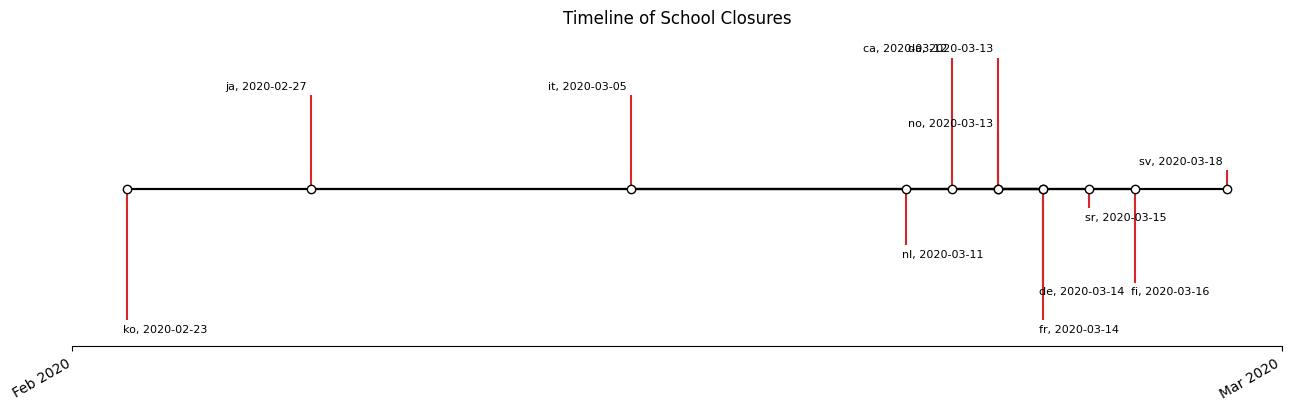

In [4]:
import matplotlib.dates as mdates
df_intervention_copy = df_interventions.copy()

#We create a timeline of the school closures
df_intervention_copy['School closure'] = pd.to_datetime(df_intervention_copy['School closure'])

levels = np.tile([-7, 7, -5, 5, -3, 3, -1, 1], int(np.ceil(len(df_intervention_copy)/8)))[:len(df_intervention_copy)]

fig, ax = plt.subplots(figsize=(12.8, 4), constrained_layout=True)
ax.set(title="Timeline of School Closures")

ax.vlines(df_intervention_copy['School closure'], 0, levels, color="tab:red")

ax.plot(df_intervention_copy['School closure'], np.zeros_like(df_intervention_copy['School closure']), "-o", color="k", markerfacecolor="w")

for d, l, r in zip(df_intervention_copy['School closure'], levels, df_intervention_copy['lang']):
    if pd.notnull(d):
        formatted_date = d.strftime('%Y-%m-%d')
    else:
        formatted_date = "Date Unknown"  

    ax.annotate(
        f"{r}, {formatted_date}",
        xy=(d, l),
        xytext=(-3, np.sign(l)*3),
        textcoords="offset points",
        horizontalalignment="right" if l > 0 else "left",
        verticalalignment="bottom" if l > 0 else "top",
        fontsize=8
    )

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

ax.yaxis.set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.margins(y=0.1)

plt.savefig('timeline.png')
plt.show()

# Divide our dataframe in two dataframes (one before and one during/after covid)

In order to be able to clearly see the difference in trends between pre and post-covid, we create two different dataframes. And we also remove the outliers, so that our analysis is not truncated.
The two dataframes created contains the pageviews for each topic in each language

In [5]:
#Divide our datasets in two dataframes (one before and one during/after covid)
df_timeseries_ = df_timeseries[df_timeseries.topic != 'ALL'].groupby(["language", "topic"])["pageviews_per_page"].sum().reset_index()

# pivot the dataset to have topics as features and each row should represent a language
df_timeseries_ = df_timeseries_.pivot(index='language', columns='topic', values='pageviews_per_page').reset_index()

df_timeseries_['total_pageviews'] = df_timeseries_.drop('language', axis=1).sum(axis=1)

languages = df_interventions['lang'].unique()

# Create an empty dictionary to store the cropped timeseries data for each language
cropped_timeseries = {}

for language in languages:
    if language != 'en':
        # Get the school closure date for the current language
        closure_date = df_interventions.loc[df_interventions['lang'] == language, 'School closure'].values[0]
        
        cropped_data = df_timeseries.loc[(df_timeseries['language'].str.contains(language, case=False, na=False)) & (df_timeseries['date'] < closure_date)]
        cropped_timeseries[language] = cropped_data


languages = df_interventions['lang'].unique()

# Create an empty dictionary to store the cropped timeseries data for each language
cropped_timeseries = {}
cropped_timeseries_2 = {}


for language in languages:
    if language != 'en': # We don't take english 
        closure_date = df_interventions.loc[df_interventions['lang'] == language, 'School closure'].values[0]
        
        cropped_data = df_timeseries.loc[(df_timeseries['language'].str.contains(language, case=False, na=False)) & (df_timeseries['date'] < closure_date)]
        cropped_data_2 = df_timeseries.loc[(df_timeseries['language'].str.contains(language, case=False, na=False)) & (df_timeseries['date'] >= closure_date)]
        
        cropped_timeseries[language] = cropped_data
        cropped_timeseries_2[language] = cropped_data_2

Data_before_covid = pd.concat(cropped_timeseries.values())
Data_after_covid = pd.concat(cropped_timeseries_2.values())

# Remove the outliers from our dataframes
def remove_outliers(group):
    Q1 = group['pageviews'].quantile(0)
    Q3 = group['pageviews'].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['pageviews'] >= lower_bound) & (group['pageviews'] <= upper_bound)]


filtered_data_after = Data_after_covid.copy().groupby(['language', 'topic']).apply(remove_outliers).reset_index(drop=True)
filtered_data_bef =Data_before_covid.copy().groupby(['language', 'topic']).apply(remove_outliers).reset_index(drop=True)

display(filtered_data_after)
display(filtered_data_bef)

,pageviews,pageviews_per_page,language,date,topic,proportion,proportion_smooth,pdi,idv,mas,uai,ltowvs,ivr
0,478365.0,0.745081,ca,2020-03-12,ALL,1.000000,NaN,57,51,42,86,48,44
1,412562.0,0.642589,ca,2020-03-13,ALL,1.000000,NaN,57,51,42,86,48,44
2,364813.0,0.568217,ca,2020-03-14,ALL,1.000000,NaN,57,51,42,86,48,44
3,383545.0,0.597393,ca,2020-03-15,ALL,1.000000,NaN,57,51,42,86,48,44
4,462607.0,0.720537,ca,2020-03-16,ALL,1.000000,NaN,57,51,42,86,48,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223626,34161.0,3.877085,sv.m,2020-07-27,STEM.Technology,0.016656,0.016009,31,71,5,29,53,78
223627,35828.0,4.066281,sv.m,2020-07-28,STEM.Technology,0.017058,0.015938,31,71,5,29,53,78
223628,37773.0,4.287028,sv.m,2020-07-29,STEM.Technology,0.018226,0.015867,31,71,5,29,53,78
223629,35693.0,4.050959,sv.m,2020-07-30,STEM.Technology,0.017589,0.015796,31,71,5,29,53,78


,pageviews,pageviews_per_page,language,date,topic,proportion,proportion_smooth,pdi,idv,mas,uai,ltowvs,ivr
0,111910.0,0.174306,ca,2018-01-01,ALL,1.000000,NaN,57,51,42,86,48,44
1,198405.0,0.309027,ca,2018-01-02,ALL,1.000000,NaN,57,51,42,86,48,44
2,188728.0,0.293955,ca,2018-01-03,ALL,1.000000,NaN,57,51,42,86,48,44
3,203167.0,0.316444,ca,2018-01-04,ALL,1.000000,NaN,57,51,42,86,48,44
4,168126.0,0.261866,ca,2018-01-05,ALL,1.000000,NaN,57,51,42,86,48,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217922,27337.0,3.102599,sv.m,2020-03-13,STEM.Technology,0.017051,0.018897,31,71,5,29,53,78
1217923,31914.0,3.622063,sv.m,2020-03-14,STEM.Technology,0.016511,0.018891,31,71,5,29,53,78
1217924,42345.0,4.805924,sv.m,2020-03-15,STEM.Technology,0.020746,0.018886,31,71,5,29,53,78
1217925,29899.0,3.393372,sv.m,2020-03-16,STEM.Technology,0.019992,0.018881,31,71,5,29,53,78


# Create dataframes that contain the proportion of pageviews of each topic for each language

We take the proportion as the median over the proprtions for all the days in the given time period for a given language/topic pair

In [6]:
# Create two dataframes (one before and one during/after covid) that contains the proportion of each topic

pre_covid_dfs = []
covid_dfs = []
lang_codes = ["ja", "ko", "sv" , "no", "fi", "da", "sr", "it" , "ca", "nl", "fr", "de"]
codes = lang_codes + [x + '.m' for x in lang_codes]

median_proportions = {}  # Dictionary to store median proportions for each language

for language in lang_codes:
    language_data = agg[language]
    language_data_mobile = agg[language + '.m']
    
    all_sum = pd.Series(language_data['sum']) + pd.Series(language_data_mobile['sum'])
    
    if 0 in all_sum.values:
        all_sum.replace(0, 1, inplace=True)

    closure_date = df_interventions[df_interventions['lang'] == language]['School closure'].iloc[0]
    for topic, topic_data in language_data["topics"].items():

        topic_data_mobile = language_data_mobile["topics"][topic]
        topic_sum = pd.Series(topic_data['sum']) + pd.Series(topic_data_mobile['sum']) # number of pageviews per day for a topic
        topic_df = pd.DataFrame({
            'pageviews': topic_sum.values,
            'language': [language] * len(topic_sum),
            'date': pd.to_datetime(topic_sum.index),
            'topic': [topic] * len(topic_sum),
            'proportion': np.divide(topic_sum.values, all_sum.values)
        })
        pre_covid_dfs.append(topic_df[topic_df['date'] < closure_date])
        covid_dfs.append(topic_df[topic_df['date'] >= closure_date])
        
pre_covid_df = pd.concat(pre_covid_dfs, ignore_index=True)
covid_df = pd.concat(covid_dfs, ignore_index=True)

for language in lang_codes:
    for topic in pre_covid_df['topic'].unique():
        language_proportions = pre_covid_df[(pre_covid_df.language == language) & (pre_covid_df.topic == topic)]['proportion']
        median_proportion = language_proportions.median()
        median_proportions[(language, topic)] = median_proportion

for language in lang_codes:
    for topic in covid_df['topic'].unique():
        language_proportions = covid_df[(covid_df.language == language) & (covid_df.topic == topic)]['proportion']
        median_proportion = language_proportions.median()
        median_proportions[(language, topic)] = median_proportion

In [7]:
duplicates_A = pre_covid_df[pre_covid_df.duplicated(subset=['language', 'topic'], keep=False)]
pre_covid_df_agg = pre_covid_df.groupby(['language', 'topic']).median().reset_index()
df_topics_before = pre_covid_df_agg.pivot(index='language', columns='topic', values='proportion').reset_index()
duplicates_B = covid_df[covid_df.duplicated(subset=['language', 'topic'], keep=False)]
covid_df_agg = covid_df.groupby(['language', 'topic']).median().reset_index()
df_topics_during = covid_df_agg.pivot(index='language', columns='topic', values='proportion').reset_index()

df_topics_during.rename(columns = {'language' : 'lang_prefix'}, inplace = True)
df_topics_before.rename(columns = {'language' : 'lang_prefix'}, inplace = True)
display(df_topics_before)
display(df_topics_during)

topic,lang_prefix,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,...,STEM.Computing,STEM.Earth and environment,STEM.Engineering,STEM.Libraries & Information,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology
0,ca,0.246389,0.054822,0.017988,0.008278,0.019791,0.044401,0.010105,0.005751,0.017439,...,0.012718,0.019335,0.009086,0.002393,0.006685,0.035319,0.018727,0.195300,0.008760,0.027067
1,da,0.243373,0.058946,0.022169,0.009978,0.012444,0.042232,0.009259,0.010481,0.027403,...,0.010037,0.013805,0.017420,0.001166,0.007313,0.032463,0.016309,0.184962,0.006730,0.025431
2,de,0.209010,0.054404,0.020778,0.013933,0.010332,0.032717,0.008128,0.014178,0.044443,...,0.019315,0.009839,0.032384,0.000987,0.007818,0.050137,0.013804,0.219232,0.005447,0.038511
3,fi,0.200262,0.043203,0.023637,0.016113,0.012393,0.039806,0.009736,0.012800,0.034823,...,0.012000,0.013249,0.023591,0.000776,0.006392,0.055825,0.015503,0.231673,0.007453,0.032778
4,fr,0.271354,0.069132,0.018371,0.016043,0.009911,0.056235,0.012449,0.015414,0.052294,...,0.016189,0.009856,0.019669,0.001083,0.007471,0.040437,0.012573,0.174871,0.005926,0.032488
5,it,0.266865,0.059335,0.015245,0.013081,0.008601,0.057581,0.012659,0.017635,0.072621,...,0.010378,0.007631,0.017306,0.000959,0.005606,0.041535,0.011937,0.150364,0.005290,0.022480
6,ja,0.219218,0.040958,0.013561,0.022391,0.006499,0.103545,0.005085,0.009457,0.032338,...,0.011872,0.005982,0.020127,0.000687,0.003940,0.025778,0.007555,0.124669,0.003699,0.023044
7,ko,0.182627,0.034519,0.016629,0.021763,0.012094,0.031411,0.005721,0.005264,0.020960,...,0.033095,0.007998,0.015499,0.002149,0.012057,0.035098,0.016463,0.182656,0.006153,0.043821
8,nl,0.217573,0.048932,0.024552,0.011088,0.011311,0.033376,0.007560,0.011545,0.029422,...,0.011738,0.011755,0.020291,0.001040,0.006412,0.050836,0.012879,0.199349,0.005367,0.028771
9,no,0.237329,0.052815,0.022338,0.009610,0.016015,0.038722,0.009653,0.008236,0.020311,...,0.009231,0.015356,0.019732,0.001454,0.006003,0.034219,0.013952,0.191996,0.006841,0.027750


topic,lang_prefix,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,...,STEM.Computing,STEM.Earth and environment,STEM.Engineering,STEM.Libraries & Information,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology
0,ca,0.203355,0.052743,0.020876,0.009252,0.017830,0.045160,0.010048,0.007381,0.024683,...,0.011711,0.018263,0.009911,0.002301,0.008114,0.042294,0.020097,0.212578,0.007971,0.027661
1,da,0.243180,0.055904,0.022350,0.009828,0.012268,0.039633,0.009712,0.011344,0.032383,...,0.008831,0.010598,0.016465,0.001133,0.006490,0.030141,0.012518,0.180927,0.006871,0.023668
2,de,0.213367,0.056217,0.020944,0.017106,0.009595,0.034045,0.008694,0.015337,0.048688,...,0.017734,0.008866,0.029862,0.000913,0.007708,0.047332,0.012867,0.217464,0.005789,0.039348
3,fi,0.190513,0.043695,0.024380,0.015373,0.011400,0.038409,0.009704,0.013535,0.035938,...,0.009815,0.011387,0.022827,0.000689,0.004948,0.050150,0.011578,0.236899,0.006497,0.030067
4,fr,0.277548,0.072304,0.018239,0.017623,0.009340,0.058056,0.013094,0.016804,0.058215,...,0.013507,0.008592,0.018035,0.000917,0.006584,0.038289,0.010696,0.165047,0.005868,0.029107
5,it,0.269534,0.060203,0.013593,0.015157,0.008100,0.061949,0.014657,0.019989,0.081097,...,0.010277,0.007150,0.016037,0.000767,0.005629,0.040105,0.011592,0.148451,0.005428,0.023245
6,ja,0.221475,0.041071,0.012083,0.024264,0.006025,0.107264,0.005331,0.009873,0.033580,...,0.010838,0.005669,0.016862,0.000613,0.003906,0.024690,0.006691,0.118124,0.003652,0.021775
7,ko,0.162778,0.033670,0.016672,0.025632,0.011796,0.032191,0.006451,0.004544,0.018763,...,0.033588,0.008505,0.013505,0.002055,0.014571,0.041781,0.021666,0.210118,0.006902,0.049013
8,nl,0.222920,0.050762,0.024372,0.012413,0.010849,0.034512,0.007915,0.013009,0.035127,...,0.010184,0.010851,0.018017,0.001042,0.005911,0.051220,0.012653,0.208404,0.005618,0.027426
9,no,0.229766,0.049997,0.023479,0.009821,0.013951,0.036723,0.009625,0.008497,0.021738,...,0.007794,0.012661,0.019374,0.001394,0.004929,0.029962,0.010213,0.189658,0.006320,0.026800


# Map each topic to a more broad topic to see the difference in broad topics pre and during Covid

In [8]:
topic_mapping = {
    'STEM': ['STEM.Biology', 'STEM.Chemistry', 'STEM.Computing', 'STEM.Earth and environment',
             'STEM.Engineering', 'STEM.Libraries & Information', 'STEM.Mathematics',
             'STEM.Medicine & Health', 'STEM.Physics', 'STEM.STEM*', 'STEM.Space', 'STEM.Technology'],
    'History and Society': ['History and Society.Business and economics', 'History and Society.Education',
                            'History and Society.History', 'History and Society.Military and warfare',
                            'History and Society.Politics and government', 'History and Society.Society',
                            'History and Society.Transportation'],
    'Geography': ['Geography.Geographical', 'Geography.Regions.Africa.Africa*',
                  'Geography.Regions.Africa.Central Africa', 'Geography.Regions.Africa.Eastern Africa',
                  'Geography.Regions.Africa.Northern Africa', 'Geography.Regions.Africa.Southern Africa',
                  'Geography.Regions.Africa.Western Africa', 'Geography.Regions.Americas.Central America',
                  'Geography.Regions.Americas.North America', 'Geography.Regions.Americas.South America',
                  'Geography.Regions.Asia.Asia*', 'Geography.Regions.Asia.Central Asia',
                  'Geography.Regions.Asia.East Asia', 'Geography.Regions.Asia.North Asia',
                  'Geography.Regions.Asia.South Asia', 'Geography.Regions.Asia.Southeast Asia',
                  'Geography.Regions.Asia.West Asia', 'Geography.Regions.Europe.Eastern Europe',
                  'Geography.Regions.Europe.Europe*', 'Geography.Regions.Europe.Northern Europe',
                  'Geography.Regions.Europe.Southern Europe', 'Geography.Regions.Europe.Western Europe',
                  'Geography.Regions.Oceania'],
    'Culture': ['Culture.Biography.Biography*', 'Culture.Biography.Women', 'Culture.Food and drink',
                'Culture.Internet culture', 'Culture.Linguistics', 'Culture.Literature', 'Culture.Media.Books',
                'Culture.Media.Entertainment', 'Culture.Media.Films', 'Culture.Media.Media*', 'Culture.Media.Music',
                'Culture.Media.Radio', 'Culture.Media.Software', 'Culture.Media.Television', 'Culture.Media.Video games',
                'Culture.Performing arts', 'Culture.Philosophy and religion', 'Culture.Sports',
                'Culture.Visual arts.Architecture', 'Culture.Visual arts.Comics and Anime', 'Culture.Visual arts.Fashion',
                'Culture.Visual arts.Visual arts*']
}

mapped_timeseries_df_aft = pd.DataFrame(columns=['STEM', 'History and Society', 'Geography', 'Culture'])
for category, sub_topics in topic_mapping.items():
    mapped_timeseries_df_aft[category] = df_topics_during[sub_topics].sum(axis=1)
mapped_timeseries_df_aft['lang_prefix'] = df_topics_during['lang_prefix']

display(mapped_timeseries_df_aft)

,STEM,History and Society,Geography,Culture,lang_prefix
0,0.450358,0.225059,0.725624,0.741911,ca
1,0.376065,0.234461,0.754026,0.835879,da
2,0.459014,0.239430,0.656276,0.861997,de
3,0.487373,0.239029,0.598919,0.795539,fi
4,0.349922,0.219182,0.725509,1.086187,fr
5,0.317427,0.209315,0.701220,1.158292,it
6,0.251083,0.143714,0.661289,0.986444,ja
7,0.460262,0.185038,0.650506,0.673455,ko
8,0.434933,0.217060,0.656593,0.842108,nl
9,0.392976,0.240749,0.832899,0.785012,no


In [9]:
mapped_timeseries_df_bef = pd.DataFrame(columns=['STEM', 'History and Society', 'Geography', 'Culture'])
for category, sub_topics in topic_mapping.items():
    mapped_timeseries_df_bef[category] = df_topics_before[sub_topics].sum(axis=1)
mapped_timeseries_df_bef['lang_prefix'] = df_topics_before['lang_prefix']

display(mapped_timeseries_df_bef)

,STEM,History and Society,Geography,Culture,lang_prefix
0,0.409787,0.227755,0.839203,0.736344,ca
1,0.388422,0.245947,0.774992,0.854608,da
2,0.460086,0.237926,0.673947,0.840383,de
3,0.483943,0.244537,0.630318,0.834056,fi
4,0.371383,0.219494,0.738161,1.056823,fr
5,0.317444,0.197322,0.725576,1.139424,it
6,0.262608,0.150958,0.671539,0.977234,ja
7,0.401416,0.181193,0.719092,0.725576,ko
8,0.419041,0.209982,0.678632,0.825931,nl
9,0.395084,0.247585,0.860805,0.819247,no


## We can see that the interest in broad topics didn't change due to the pandemic

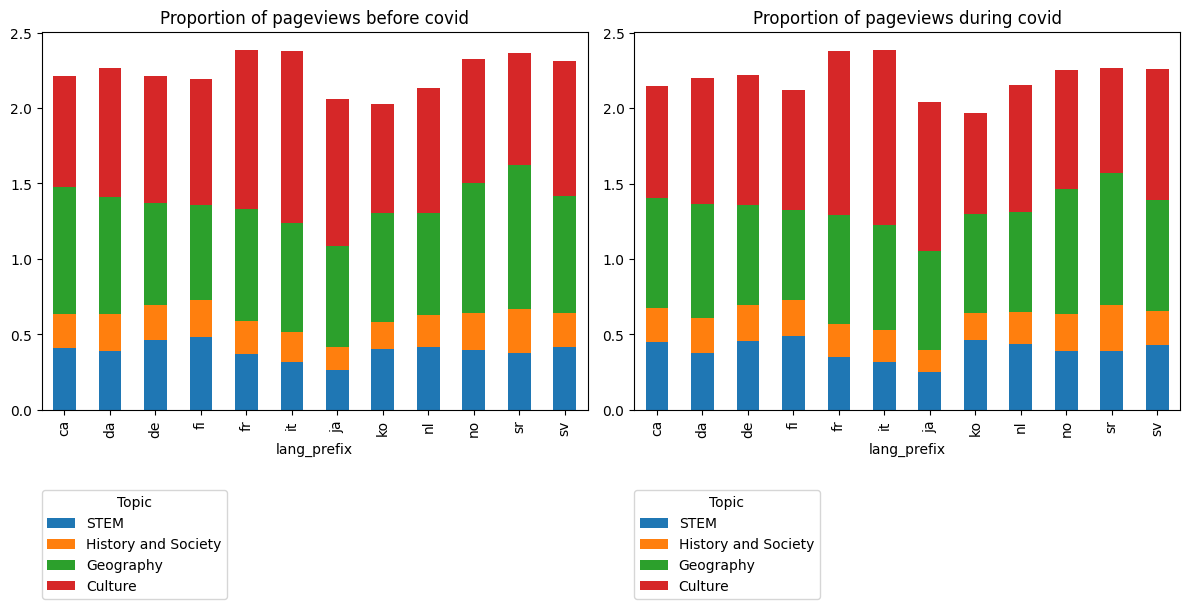

In [10]:
# Display the difference in the proportion of topics before and during/after Covid
fig, axes = plt.subplots(1, 2, figsize=(12, 7))

mapped_timeseries_df_bef.plot.bar(x='lang_prefix', stacked=True, title='Proportion of pageviews before covid', ax=axes[0])
axes[0].legend(title='Topic', loc=(0, -0.5))

mapped_timeseries_df_aft.plot.bar(x='lang_prefix', stacked=True, title='Proportion of pageviews during covid', ax=axes[1])
axes[1].legend(title='Topic', loc=(0, -0.5))

plt.tight_layout()
#plt.savefig('Proportion_of_pagviews_bef_after')
plt.show()


# We can look at topics individually to see their trend

In this part we display that change in proportion for Biology and Sports, which are the two topics that changed the msot.

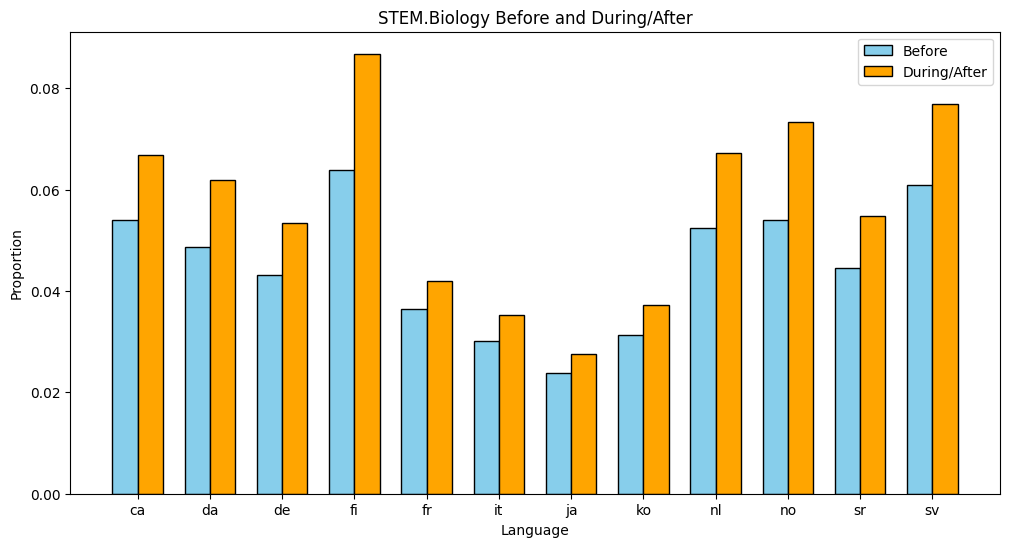

In [11]:
# We plot the difference in proportion for each topic between before and during/after Covid
def plot_before_after(df_bef, df_aft, category):
    df_bef2 = df_bef.copy()
    df_aft2 = df_aft.copy()
    df_bef2.set_index('lang_prefix', inplace=True)
    df_aft2.set_index('lang_prefix', inplace=True)

    # Check if the category exists in both DataFrames
    if category not in df_bef2.columns or category not in df_aft2.columns:
        print(f"Category '{category}' not found in both DataFrames.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.35

    categories = df_bef2.index
    positions_bef = np.arange(len(categories))
    positions_aft = positions_bef + bar_width

    ax.bar(positions_bef, df_bef2[category], width=bar_width, color='skyblue', edgecolor='black', label='Before')

    ax.bar(positions_aft, df_aft2[category], width=bar_width, color='orange', edgecolor='black', label='During/After')

    ax.set_title(f'{category} Before and During/After')
    ax.set_xlabel('Language')
    ax.set_ylabel('Proportion')
    ax.set_xticks(positions_bef + bar_width / 2)
    ax.set_xticklabels(categories)
    ax.legend()

    # Show the plot
    plt.show()

plot_before_after(df_topics_before.copy(), df_topics_during.copy(), 'STEM.Biology')

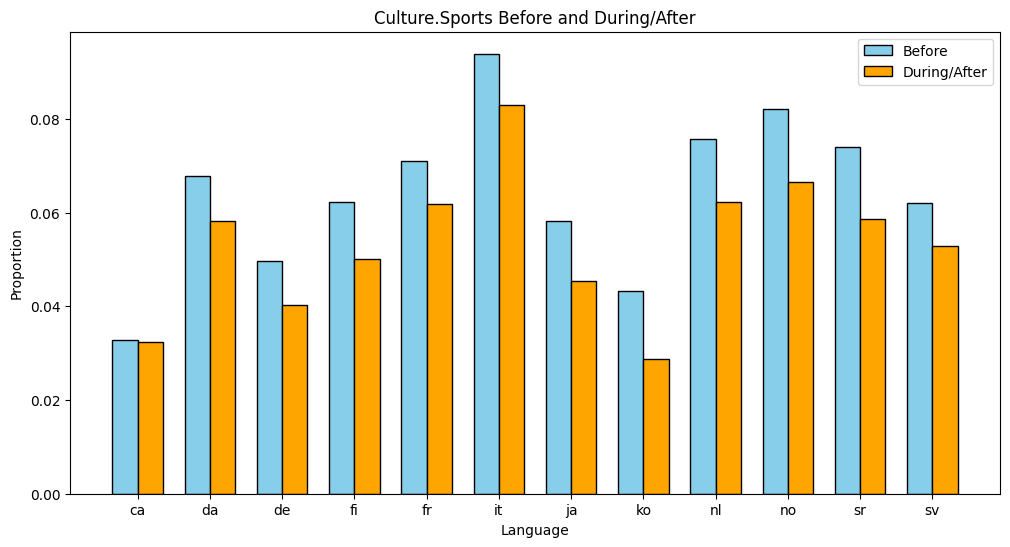

In [12]:
plot_before_after(df_topics_before.copy(), df_topics_during.copy(), 'Culture.Sports')

In [13]:
# Create a dataframe with the raw values of pageviews for each topic
df_timeseries_bef_raw = filtered_data_bef[filtered_data_bef.topic != 'ALL'].groupby(["language", "topic"])["pageviews"].mean().reset_index()

# pivot the dataset to have topics as features and each row should represent a language
df_timeseries_bef_raw = df_timeseries_bef_raw.pivot(index='language', columns='topic', values='pageviews').reset_index()

df_timeseries_bef_raw['total_pageviews'] = df_timeseries_bef_raw.drop('language', axis=1).sum(axis=1)

df_timeseries_bef_raw['lang_prefix'] = df_timeseries_bef_raw['language'].str[:2]
df_timeseries_bef_raw = df_timeseries_bef_raw.drop('language', axis = 1)
df_timeseries_bef_raw = df_timeseries_bef_raw.groupby(['lang_prefix'], as_index=False).agg({
    **{topic: 'sum' for topic in df_timeseries_bef_raw.columns if topic not in ['lang_prefix']},
})

display(df_timeseries_bef_raw)

topic,lang_prefix,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,...,STEM.Earth and environment,STEM.Engineering,STEM.Libraries & Information,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology,total_pageviews
0,ca,1.272008e+05,2.831176e+04,9338.342500,4433.980843,10280.839159,2.296373e+04,5366.309857,3023.683218,9.430749e+03,...,10223.836454,4790.532579,1255.423131,3584.801498,1.853844e+04,9899.040865,1.023017e+05,5174.537988,1.444903e+04,1.154196e+06
1,da,2.080159e+05,5.080356e+04,18694.731880,8426.609754,10503.253000,3.567766e+04,7956.941256,9009.347880,2.465771e+04,...,11299.923867,14614.770000,975.519274,5944.028528,2.702250e+04,13072.490644,1.534537e+05,5674.211212,2.061690e+04,1.921753e+06
2,de,5.891876e+06,1.548285e+06,572306.211903,387276.564838,282396.589041,9.117558e+05,228307.374499,400770.252802,1.308983e+06,...,273340.168400,886609.428394,27088.714736,210469.763387,1.342617e+06,373913.186017,5.910127e+06,158245.697954,1.018890e+06,6.134996e+07
3,fi,3.600947e+05,7.918703e+04,42514.085714,28980.117483,22448.062189,7.243377e+04,17563.823827,23515.706911,6.568486e+04,...,23802.325794,42331.399868,1401.261777,11360.957518,9.874711e+04,27665.400343,4.112988e+05,13646.747873,5.716413e+04,3.971350e+06
4,fr,5.632658e+06,1.440005e+06,383574.353674,330242.696223,203371.298893,1.166341e+06,259897.011208,321166.586692,1.102806e+06,...,205054.728622,403818.714163,22249.580886,148709.383562,8.279861e+05,256162.554274,3.559148e+06,125197.059332,6.474496e+05,4.955990e+07
5,it,4.385282e+06,9.777019e+05,250726.525189,214098.852948,139934.335758,9.514243e+05,212760.210888,290424.275884,1.218678e+06,...,126358.282213,285213.653738,15702.884335,89497.515113,6.679620e+05,190112.958985,2.396580e+06,89765.256704,3.568735e+05,3.910776e+07
6,ja,7.389645e+06,1.399495e+06,450855.358323,751072.971593,218295.267605,3.508921e+06,172985.709765,328760.605546,1.114742e+06,...,201632.586498,664846.273537,22489.228492,127165.893266,8.622085e+05,244475.814871,3.974404e+06,125836.524054,7.094812e+05,6.917954e+07
7,ko,4.007449e+05,7.736312e+04,36337.696543,48547.531388,27212.020377,6.935306e+04,12724.338007,11587.677390,4.687882e+04,...,17559.002571,33963.006410,4785.782674,27549.082614,7.725682e+04,37557.401022,4.064471e+05,13696.570224,9.429404e+04,4.465360e+06
8,nl,9.932969e+05,2.241538e+05,110302.208750,49414.359576,50500.665648,1.490774e+05,34040.705000,52604.597500,1.378980e+05,...,53097.633449,90511.391740,4621.898957,27953.437500,2.231963e+05,57125.494355,8.815009e+05,24331.258339,1.253732e+05,9.679603e+06
9,no,2.379820e+05,5.414178e+04,22082.554863,9450.422861,15768.474626,3.779524e+04,9477.524646,8240.504489,2.112253e+04,...,15338.245061,19279.278585,1450.124807,5808.824225,3.364096e+04,13374.875340,1.859230e+05,7507.970440,2.623496e+04,2.308892e+06


In [14]:
df_timeseries_aft_raw = filtered_data_after[filtered_data_after.topic != 'ALL'].groupby(["language", "topic"])["pageviews"].mean().reset_index()

# pivot the dataset to have topics as features and each row should represent a language
df_timeseries_aft_raw = df_timeseries_aft_raw.pivot(index='language', columns='topic', values='pageviews').reset_index()

df_timeseries_aft_raw['total_pageviews'] = df_timeseries_aft_raw.drop('language', axis=1).sum(axis=1)

df_timeseries_aft_raw['lang_prefix'] = df_timeseries_aft_raw['language'].str[:2]
df_timeseries_aft_raw = df_timeseries_aft_raw.drop('language', axis = 1)
df_timeseries_aft_raw = df_timeseries_aft_raw.groupby(['lang_prefix'], as_index=False).agg({
    **{topic: 'sum' for topic in df_timeseries_aft_raw.columns if topic not in ['lang_prefix']},
})
display(df_timeseries_aft_raw)

topic,lang_prefix,Culture.Biography.Biography*,Culture.Biography.Women,Culture.Food and drink,Culture.Internet culture,Culture.Linguistics,Culture.Literature,Culture.Media.Books,Culture.Media.Entertainment,Culture.Media.Films,...,STEM.Earth and environment,STEM.Engineering,STEM.Libraries & Information,STEM.Mathematics,STEM.Medicine & Health,STEM.Physics,STEM.STEM*,STEM.Space,STEM.Technology,total_pageviews
0,ca,1.199174e+05,2.966844e+04,10399.962791,5242.809099,10259.471431,2.533210e+04,5944.853924,4038.485915,1.405490e+04,...,10416.704225,5668.077465,1299.504271,4600.429577,2.392958e+04,11370.225352,1.204298e+05,4587.773050,1.585658e+04,1.222015e+06
1,da,1.981667e+05,4.715987e+04,18167.092199,8084.409409,10141.727287,3.331992e+04,8412.817730,9061.546099,2.800312e+04,...,9533.439716,13313.511499,948.060835,5742.182118,2.603080e+04,12117.226440,1.527412e+05,5816.388387,1.899355e+04,1.831978e+06
2,de,6.172745e+06,1.645124e+06,595477.628571,493796.814286,267395.835714,9.837485e+05,256134.664029,448944.388820,1.473815e+06,...,254869.935714,832841.728571,25528.605839,214515.385714,1.345047e+06,353191.600000,6.025172e+06,175977.565009,1.064907e+06,6.326565e+07
3,fi,3.581599e+05,8.206302e+04,45479.594203,29104.202899,22022.739130,7.290483e+04,18799.173913,25126.231884,6.913878e+04,...,25401.644928,42174.021739,1298.781417,10930.347826,9.573183e+04,27605.681159,4.454169e+05,12727.483253,5.647952e+04,4.039105e+06
4,fr,6.455716e+06,1.679310e+06,418084.942857,405078.521429,214242.942857,1.340709e+06,314359.907143,403874.742857,1.383094e+06,...,197384.042857,407595.678571,20911.763258,151940.535714,9.044233e+05,248644.542857,3.758990e+06,140493.639868,6.539968e+05,5.527424e+07
5,it,5.127846e+06,1.154428e+06,262529.684564,291342.557047,153853.892617,1.206217e+06,296951.703876,392596.308725,1.629539e+06,...,146220.442953,292303.456376,14580.876973,104896.651007,7.699989e+05,218318.859060,2.785127e+06,107712.236952,4.413351e+05,4.589745e+07
6,ja,8.450956e+06,1.585739e+06,451775.935897,927084.666667,223136.064103,4.052311e+06,202396.121795,401727.937060,1.339690e+06,...,215745.839744,625272.044872,22815.891026,149230.154881,9.200967e+05,268600.025641,4.295115e+06,141276.740762,7.633384e+05,7.719911e+07
7,ko,3.958812e+05,8.225838e+04,39149.937500,61759.133814,28548.987500,7.677287e+04,15400.678223,10952.675431,4.578506e+04,...,21023.962500,32481.606250,4952.162500,35062.068750,1.013935e+05,51518.506250,5.059197e+05,16673.729560,1.131446e+05,4.747241e+06
8,nl,1.063708e+06,2.406265e+05,116900.265734,60007.251748,52111.468531,1.667952e+05,40119.496503,61609.203209,1.742534e+05,...,52583.958042,85195.615385,4977.361702,28602.776224,2.497013e+05,57017.772519,9.721864e+05,28887.683787,1.318726e+05,1.032515e+07
9,no,2.159161e+05,4.785267e+04,21696.829787,9255.946426,14304.919706,3.445511e+04,9146.709220,8072.234043,2.159563e+04,...,12993.037487,17987.602837,1336.947425,5254.531915,3.002228e+04,11209.744681,1.795263e+05,6272.003929,2.438572e+04,2.140094e+06


### We can now look at the raw values and not just the proportion
We can see that the total pageviews increased for most countries

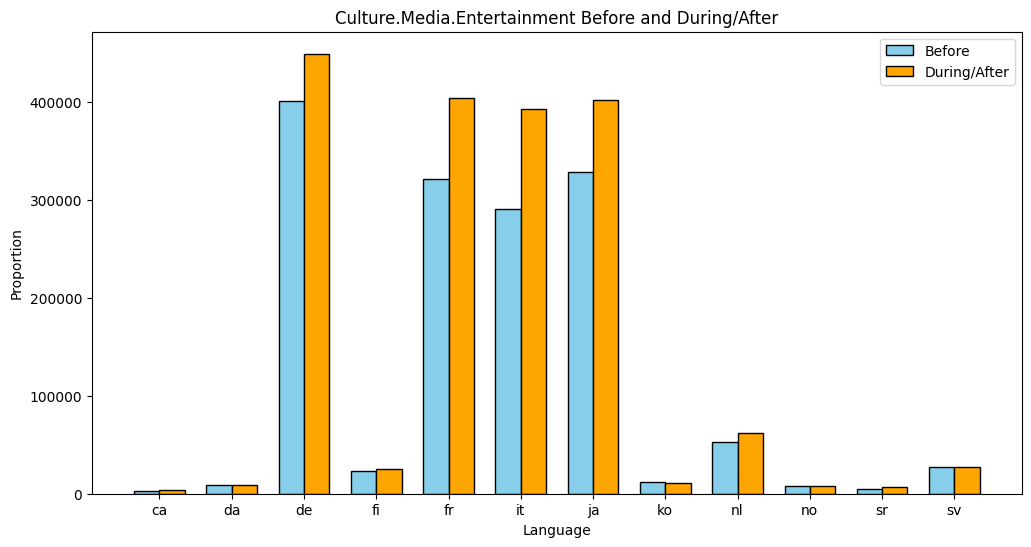

In [15]:
# Plot the difference in pageviews for a topic between before and during/after Covid
plot_before_after(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Media.Entertainment')

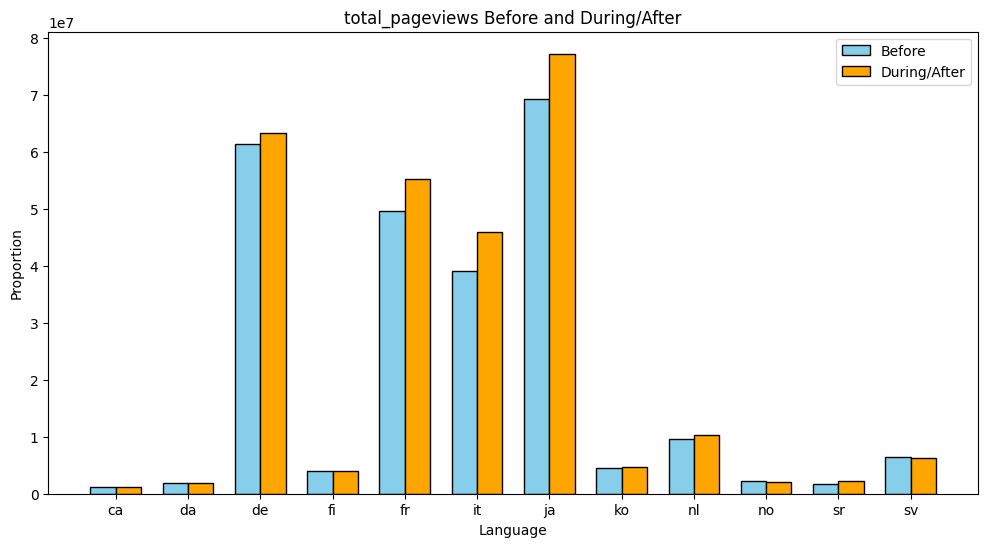

In [16]:
plot_before_after(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'total_pageviews')

# We now look at the percentage growth of pageviews for different topics

In [17]:
# Create a function to show the growth in interest for topics
def topic_growth_1(df_bef, df_aft, category):
    df_bef.set_index('lang_prefix', inplace=True)
    df_aft.set_index('lang_prefix', inplace=True)

    if category not in df_bef.columns or category not in df_aft.columns:
        print(f"Category '{category}' not found in both DataFrames.")
        return

    # Filter out the 'ca' language as the sample is too small
    df_bef = df_bef[df_bef.index != 'ca']
    df_aft = df_aft[df_aft.index != 'ca']

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.35

    categories = df_bef.index
    positions_bef = np.arange(len(categories))
    positions_aft = positions_bef + bar_width

    # Topic growth is defined as the growth in views in a topic minus the overall growth in pageviews 
    growth = ((df_aft[category] - df_bef[category]) / df_bef[category] - (df_aft['total_pageviews'] - df_bef['total_pageviews']) / df_bef['total_pageviews']) * 100

    # Set the color of the bars based on the growth value
    colors = ['red' if g < 0 else 'green' for g in growth]

    # Plot the bar chart for df_bef
    ax.bar(positions_bef, growth, width=bar_width, color=colors, edgecolor='black', label='Topic growth')

    # Add titles and labels
    ax.set_title(f'Growth in {category} between Before and During/After Covid')
    ax.set_xlabel('Language')
    ax.set_ylabel('Growth in %')
    ax.set_xticks(positions_bef + bar_width / 2)
    ax.set_xticklabels(categories)
    #ax.legend()

    #plt.savefig('Sports.png')
    plt.show()

# We display the topics that had a growth increase

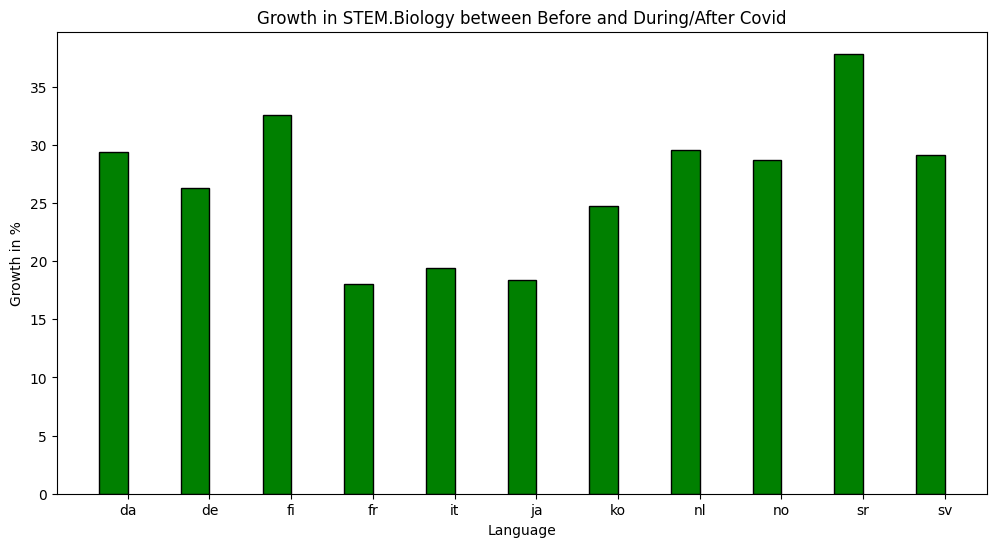

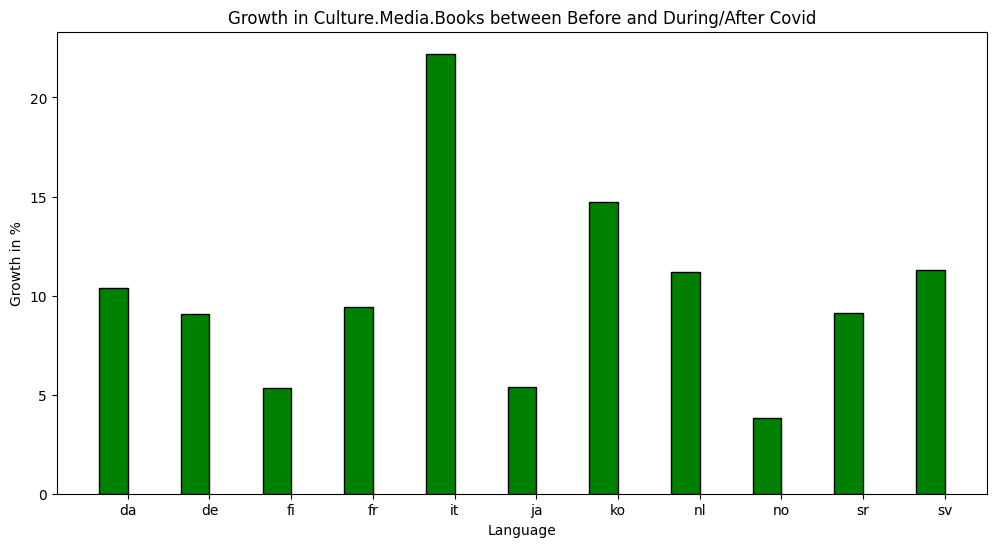

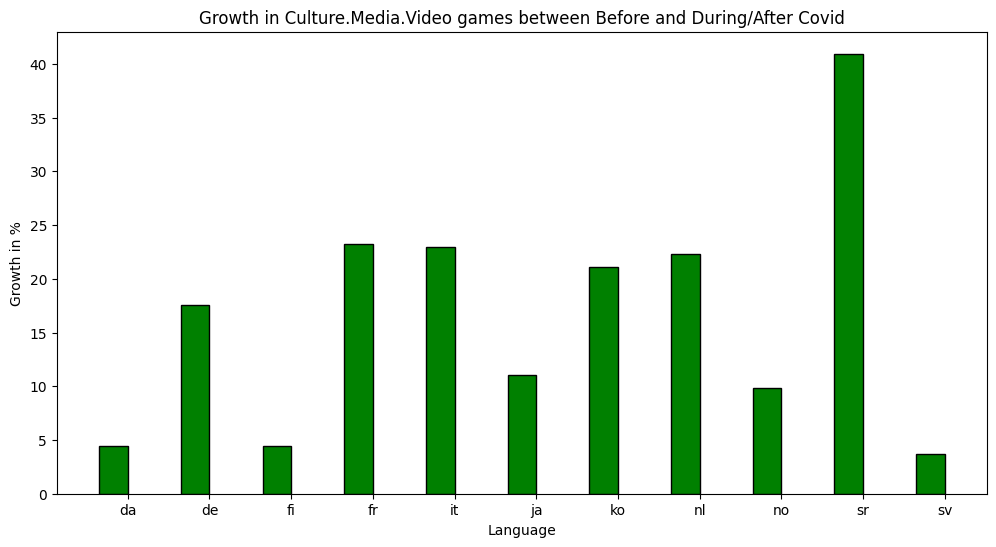

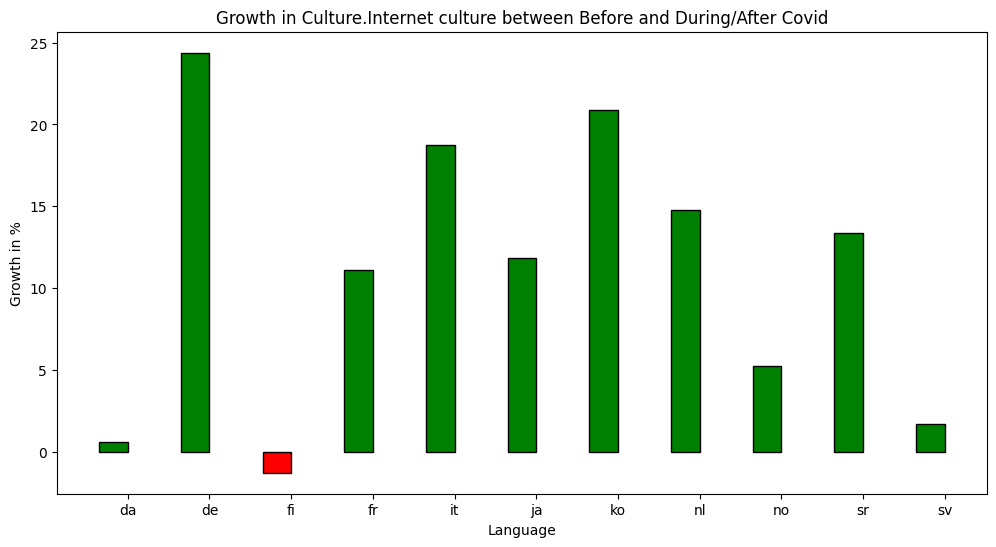

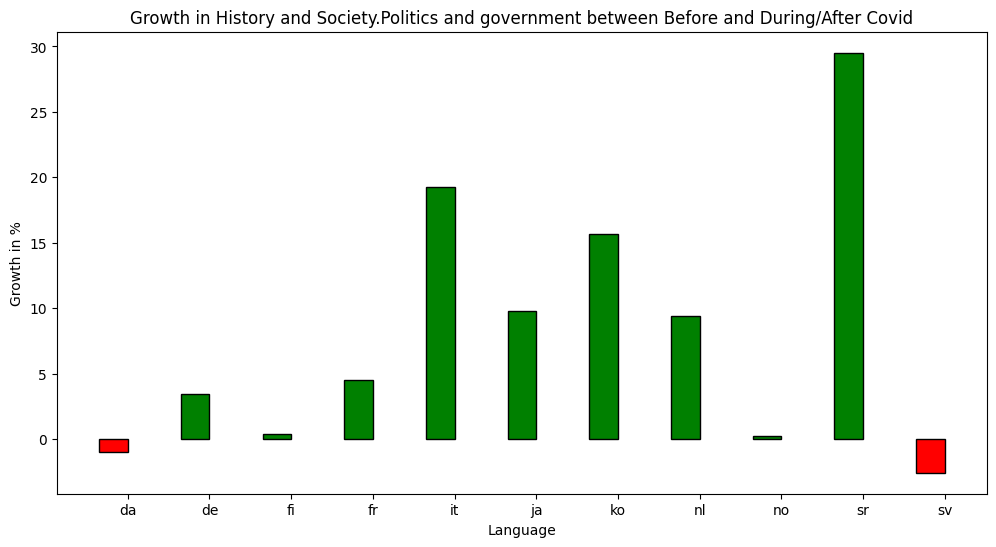

In [18]:
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'STEM.Biology')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Media.Books')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Media.Video games')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Internet culture')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'History and Society.Politics and government')

# We display the topics that had a growth decrease


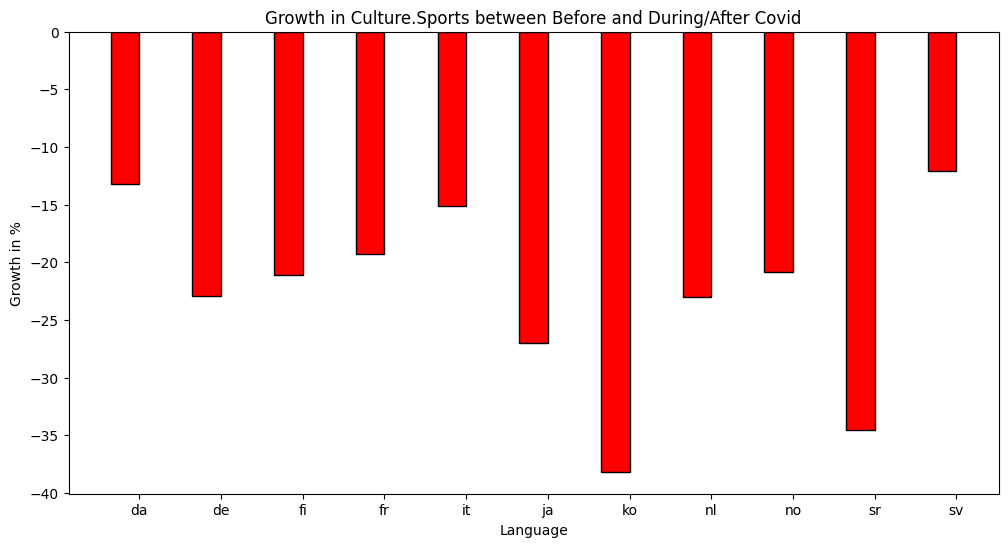

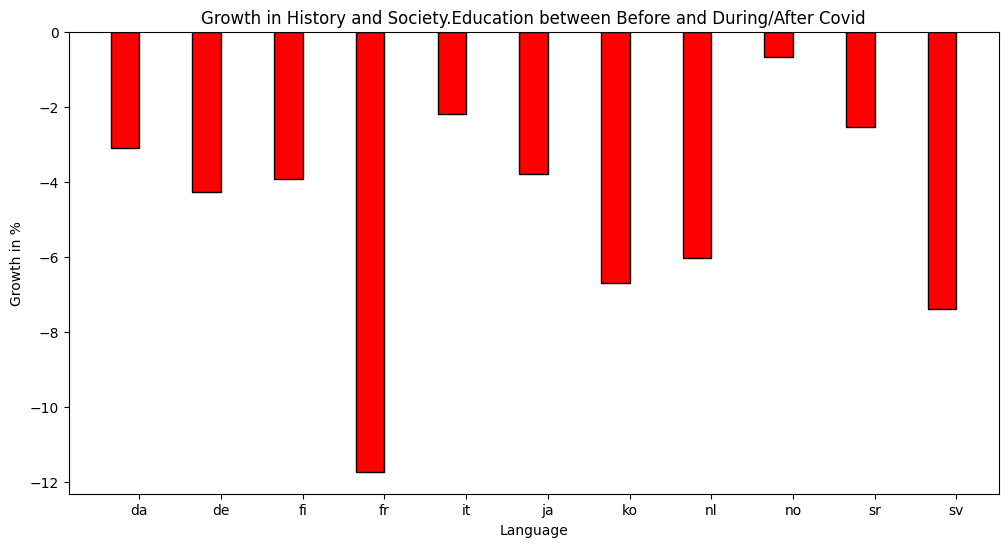

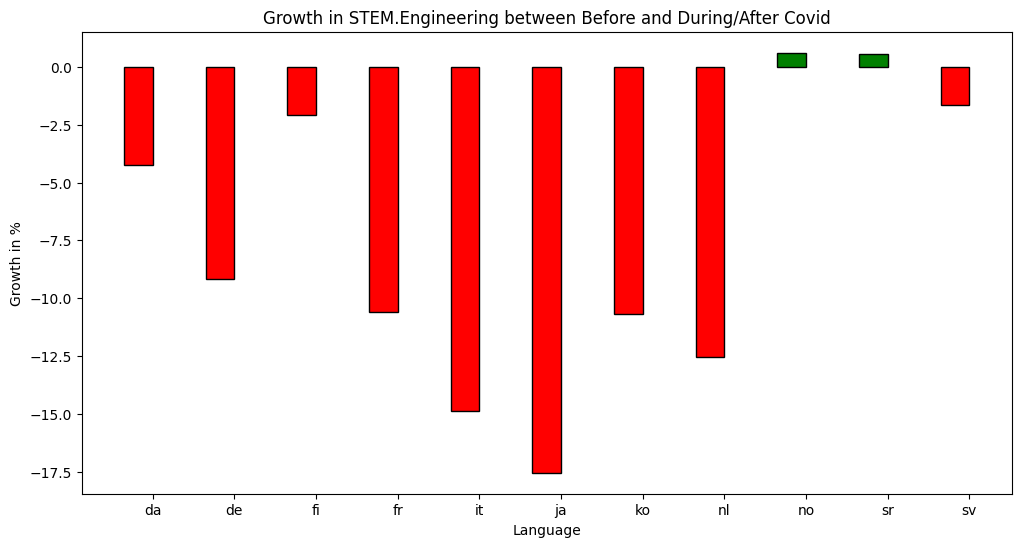

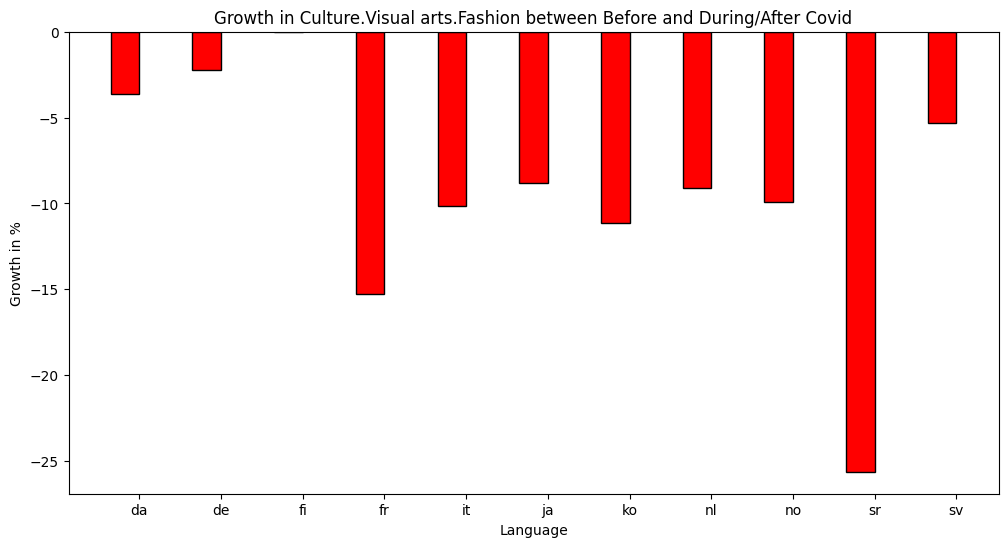

In [21]:
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Sports')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'History and Society.Education')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'STEM.Engineering')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Visual arts.Fashion')

# Different trends in South Korea 
We noticed that South Korea had different trends compared to other countries in Media, Enterntainement and Films topics (as shown in the following plots).

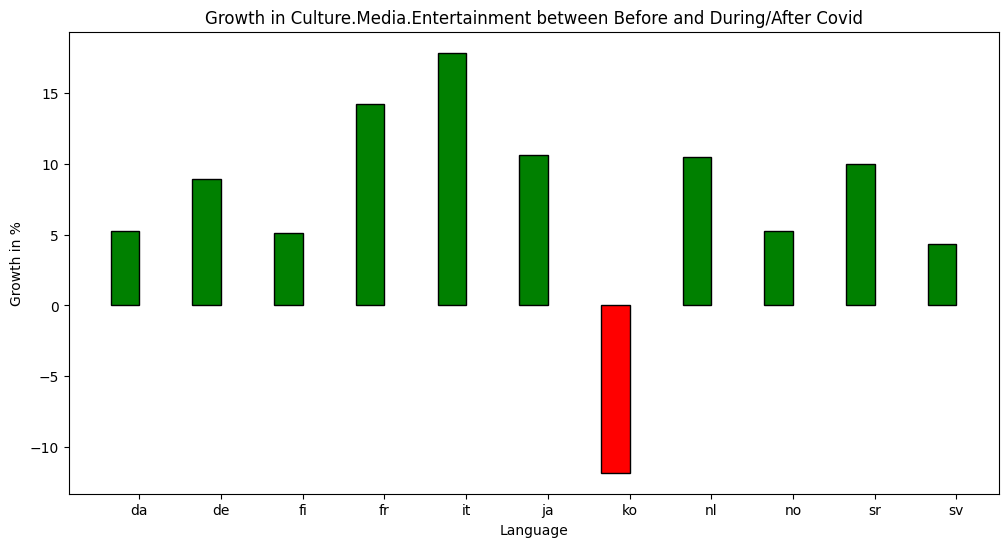

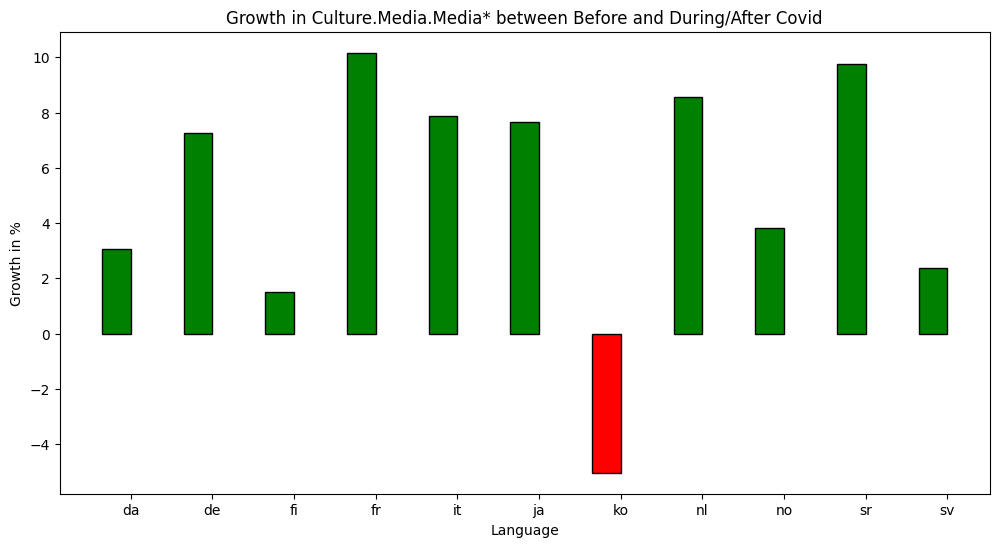

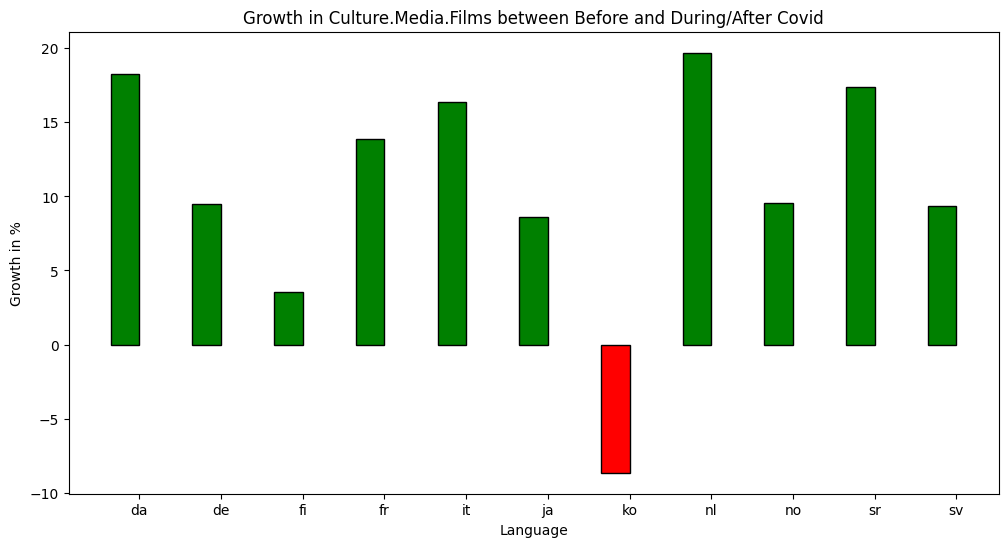

In [22]:
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Media.Entertainment')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Media.Media*')
topic_growth_1(df_timeseries_bef_raw.copy(), df_timeseries_aft_raw.copy(), 'Culture.Media.Films')